## SVM (Support Vector Machine)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt
import joblib

In [3]:
df = pd.read_csv('dataset_final_para_modelo_1_100.csv', decimal=',')
y = df['Sinistro']
X = df.drop(columns=['Sinistro', 'data'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state= 8
)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treino: (578962, 15)
Tamanho do conjunto de teste: (248127, 15)


### 'tipo_via' possui valores Nan

In [5]:
X_train['tipo_via_num'] = X_train['tipo_via_num'].fillna(-1)
X_test['tipo_via_num'] = X_test['tipo_via_num'].fillna(-1)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

### RandomSearchCV

In [6]:
svm_model = SVC(
    class_weight='balanced', # Para lidar com desbalanceamento 2:1
    probability=True,      # Para permitir predict_proba
    random_state=8
)

param_dist = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']
}

random_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_dist,
    n_iter=10,     
    scoring='average_precision',
    cv=3,   
    verbose=2,
    n_jobs=-1,                    
    random_state=8
)

random_search.fit(X_train_scaled, y_train)

print("Busca concluída.")
print("\nMelhores parâmetros encontrados:")
print(random_search.best_params_)
print("\nMelhor score (Average Precision) no CV:")
print(random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

### Treinar o modelo final

In [ ]:
svm_model_final = SVC(
    class_weight='balanced', # Para lidar com desbalanceamento 2:1
    probability=True,      # Para permitir predict_proba
    random_state=8,
    C = 10,
    gamma = 0.1
)

svm_model_final.fit(X_train, y_train)

In [ ]:
y_pred_svm = svm_model_final.predict(X_test_scaled)
y_prob_svm = svm_model_final.predict_proba(X_test_scaled)[:, 1] # Probabilidade de acidente

### Avaliar Métricas


--- Matriz de Confusão ---


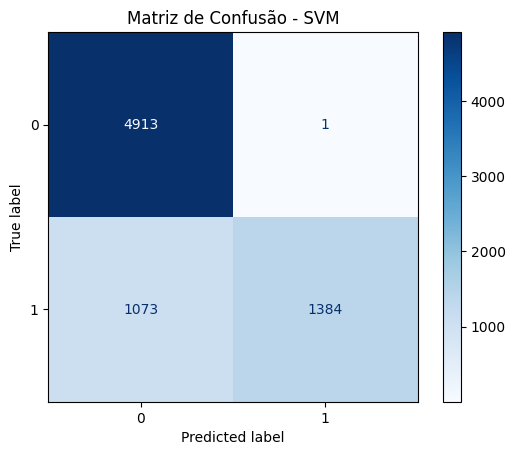

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4914
           1       1.00      0.56      0.72      2457

    accuracy                           0.85      7371
   macro avg       0.91      0.78      0.81      7371
weighted avg       0.88      0.85      0.84      7371

--- AUC (SVM) ---
0.8337


In [ ]:
print("\n--- Relatório de Classificação (Limiar ~0.5) ---")
print(classification_report(y_test, y_pred_svm))

# Matriz de Confusão
print("\n--- Matriz de Confusão ---")
cf_matrix = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Melhor SVM")
plt.savefig("svm_confusion_matrix.png")
plt.close() # Evita que o gráfico seja mostrado aqui, será mostrado na saída

# --- 4. Métricas Independentes de Limiar (AUCs) ---

# ROC-AUC
auc_svm_roc = roc_auc_score(y_test, y_prob_svm)
print(f"\n--- AUC (ROC) ---")
print(f"ROC-AUC: {auc_svm_roc:.4f}")

# Curva Precision-Recall (PR-AUC)
print("\n--- Curva Precision-Recall (PR-AUC) ---")

# Calcular Precision, Recall e Limiares
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_svm)

# Calcular a Área sob a Curva (PR-AUC)
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_prob_svm)

print(f"Average Precision (AP) / PR-AUC: {avg_precision:.4f}")

# Plotar o gráfico
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='b', label=f'Curva PR (AUC = {pr_auc:.4f})')

# Calcular e Plotar a Linha de Base (Baseline)
n_positivos = y_test.sum()
n_total = len(y_test)
baseline = n_positivos / n_total
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (Aleatório) = {baseline:.4f}')

# Configurações do gráfico
plt.title('Curva Precision-Recall (PR-AUC) - SVM')
plt.xlabel('Recall (Revocação)')
plt.ylabel('Precision (Precisão)')
plt.legend(loc='lower left')
plt.grid(True)
plt.savefig("svm_pr_auc_curve.png")
plt.close() # Evita que o gráfico seja mostrado aqui, será mostrado na saída

print("\nGráficos 'svm_confusion_matrix.png' e 'svm_pr_auc_curve.png' foram gerados.")